In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./all.csv')

In [3]:
df.head()

,code,text
0,Positive Activating,I found another interesting clue in your first...
1,Personal advice,It is good to see more details on this.
2,Vocatives (addressing individual),"Hi Daniel,Thanks for your comments."
3,Positive Deactivating,This is cool!This confirms my personal impress...
4,"Complementing, expressing appreciation",The final result is quite compelling and reall...


In [4]:
df.groupby('code')['text'].count()

code
Addresses or refers to the group using inclusive pronouns (addressing the whole group)     15
Asking questions                                                                          180
Complementing, expressing appreciation                                                    371
Course reflection                                                                           2
Expressing agreement                                                                       79
Expressing disagreement                                                                    28
Group cohesion                                                                              1
Negative Activating                                                                       157
Negative Deactivating                                                                      67
Open communication                                                                          2
Personal advice                                        

In [5]:
# over_50_cols = [
#     'Asking questions', 'Complementing, expressing appreciation', 'Expressing agreement',
#     'Negative Activating', 'Negative Deactivating', 'Personal advice',
#     'Phatics, salutations and greetings, Social sharing', 'Positive Activating',
#     'Self-disclosure & expressing values', 'Unconventional emotion expression', 'Vocatives (addressing individual)'
# ]
over_100_cols = [
    'Asking questions', 'Complementing, expressing appreciation',
    'Negative Activating', 'Personal advice',
    'Vocatives (addressing individual)'
]
df_over_50 = df[df['code'].isin(over_100_cols)]
df_over_50.groupby('code')['text'].count()

code
Asking questions                          180
Complementing, expressing appreciation    371
Negative Activating                       157
Personal advice                           202
Vocatives (addressing individual)         183
Name: text, dtype: int64

In [212]:
df_cleaned.to_csv('./filtered.csv')

In [6]:
import re
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    
    df[text_field] = df[text_field].str.lower()
    return df

In [7]:
df_cleaned = standardize_text(df_over_50, 'text')
df_cleaned.head()

/Users/chengluli/anaconda2/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chengluli/anaconda2/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/chengluli/anaconda2/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,code,text
1,Personal advice,it is good to see more details on this
2,Vocatives (addressing individual),"hi daniel,thanks for your comments"
4,"Complementing, expressing appreciation",the final result is quite compelling and reall...
5,Negative Activating,i love the lead and the conclusion drawn by th...
6,Asking questions,did you find any similarities about these two ...


In [8]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

df_cleaned["tokens"] = df_cleaned["text"].apply(tokenizer.tokenize)

/Users/chengluli/anaconda2/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df_cleaned["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_cleaned["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

Using TensorFlow backend.


13386 words total, with a vocabulary size of 2135
Max sentence length is 55


In [30]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [10]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [31]:
embeddings = get_word2vec_embeddings(word2vec, df_cleaned)

## Attention Layer

In [57]:
import keras as K
from keras.layers import *

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

## RNN

In [58]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = max(sentence_lengths)
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df_cleaned["text"].tolist())
sequences = tokenizer.texts_to_sequences(df_cleaned["text"].tolist())

rnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

factorized_codes = pd.factorize(df_cleaned["code"])[0]
factorized_codes_dict = pd.factorize(df_cleaned["code"])[1]

labels = factorized_codes

indices = np.arange(rnn_data.shape[0])
np.random.shuffle(indices)
rnn_data = rnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * rnn_data.shape[0])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 2135 unique tokens.
(2136, 300)


In [59]:
import json

with open('tokenizer.json', 'w') as outfile:  
    json.dump(tokenizer.word_index, fp=outfile)

In [67]:
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import keras_metrics as km
sc_precision = km.sparse_categorical_precision()
sc_recall = km.sparse_categorical_recall()

def rnn_text(embeddings, max_sequence_length, num_words, embedding_dim, labels_index): 
    model = Sequential()
    model.add(Embedding(num_words,
                        embedding_dim,
                        weights=[embeddings],
                        input_length=max_sequence_length,
                        mask_zero=True,
                        trainable=False))
    # model.add(Bidirectional(LSTM(100)))
    model.add(LSTM(128, return_sequences=True))
#     model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    # Attention layer not used because tfjs cannot load custom layer
    # need to figure out how
    model.add(AttentionWithContext())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(labels_index, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[sc_precision, sc_recall, 'accuracy'])
    
    return model

In [68]:
x_train = rnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = rnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

rnn_model = rnn_text(
    embedding_weights, 
    MAX_SEQUENCE_LENGTH, 
    len(word_index)+1, 
    EMBEDDING_DIM, 
    len(list(df_cleaned["code"].unique()))
)

In [69]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=80)

for mini_batch in range(200):
        rnn_history = rnn_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=64, callbacks=[es])

        precision = rnn_history.history['val_precision'][0]
        recall = rnn_history.history['val_recall'][0]
        f_score = (2.0 * precision * recall) / (precision + recall)

Train on 875 samples, validate on 218 samples
Epoch 1/1
875/875 [==============================] - 4s 5ms/step - loss: 1.5751 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.3291 - val_loss: 1.5240 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.3257
Train on 875 samples, validate on 218 samples
Epoch 1/1
 64/875 [=>............................] - ETA: 1s - loss: 1.5036 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.3438

/Users/chengluli/anaconda2/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


875/875 [==============================] - 2s 3ms/step - loss: 1.4071 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.4080 - val_loss: 1.2530 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.5183
Train on 875 samples, validate on 218 samples
Epoch 1/1
875/875 [==============================] - 3s 3ms/step - loss: 1.1666 - precision: 0.6842 - recall: 0.0867 - acc: 0.4949 - val_loss: 1.1353 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.5092
Train on 875 samples, validate on 218 samples
Epoch 1/1
875/875 [==============================] - 3s 3ms/step - loss: 1.0364 - precision: 0.7143 - recall: 0.1333 - acc: 0.5406 - val_loss: 1.0655 - val_precision: 0.8947 - val_recall: 0.3269 - val_acc: 0.5413
Train on 875 samples, validate on 218 samples
Epoch 1/1
875/875 [==============================] - 2s 3ms/step - loss: 0.9703 - precision: 0.6383 - recall: 0.4000 - acc: 0.5383 - val_loss: 0.8775 - val_precision: 0.7879 - val_recall: 0.5000 - val_acc: 0.6

In [42]:
def predict_text(model, text):
        predict = model.predict(pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)).ravel()
        return sorted([{"code": factorized_codes_dict[idx], "prob": prob} for idx, prob in enumerate(predict)], reverse=True, key=lambda x: x['prob'])
    
predict_text(rnn_model, "I think you should take it")

[{'code': 'Personal advice', 'prob': 0.95512956},
 {'code': 'Negative Activating', 'prob': 0.043820683},
 {'code': 'Asking questions', 'prob': 0.000723947},
 {'code': 'Complementing, expressing appreciation', 'prob': 0.00031136753},
 {'code': 'Vocatives (addressing individual)', 'prob': 1.431781e-05}]

In [83]:
from sklearn.metrics import classification_report

y_test = rnn_model.predict(x_val)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test, y_val))
print(factorized_codes_dict)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83        49
           1       0.47      0.46      0.47        37
           2       0.67      0.65      0.66        68
           3       0.65      0.71      0.68        24
           4       0.82      0.78      0.79        40

    accuracy                           0.69       218
   macro avg       0.68      0.69      0.69       218
weighted avg       0.69      0.69      0.69       218

Index(['Personal advice', 'Vocatives (addressing individual)',
       'Complementing, expressing appreciation', 'Negative Activating',
       'Asking questions'],
      dtype='object')


In [43]:
rnn_model.save('./rnn.h5')

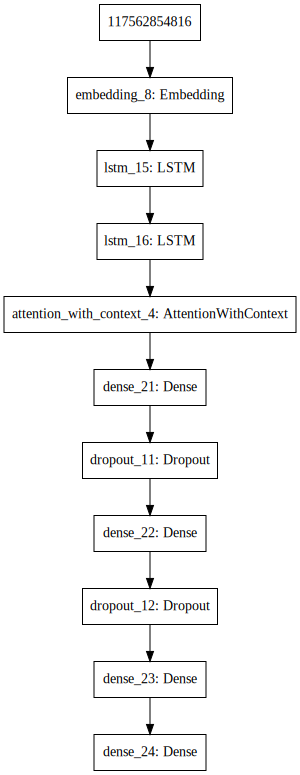

In [86]:
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras

keras.utils.vis_utils.pydot = pyd

SVG(model_to_dot(rnn_model).create(prog='dot', format='svg'))
# rnn_model.summary()

## CNN

In [42]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [43]:
factorized_codes = pd.factorize(df_cleaned["code"])[0]
factorized_codes_dict = pd.factorize(df_cleaned["code"])[1]

cnn_labels = to_categorical(np.asarray(factorized_codes))

indices = np.arange(rnn_data.shape[0])
np.random.shuffle(indices)
rnn_data = rnn_data[indices]
cnn_labels = cnn_labels[indices]

x_train = rnn_data[:-num_validation_samples]
y_train = cnn_labels[:-num_validation_samples]
x_val = rnn_data[-num_validation_samples:]
y_val = cnn_labels[-num_validation_samples:]

cnn_model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(df_cleaned["code"].unique())), False)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
cnn_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=64)

In [155]:
from keras.utils import print_summary, plot_model

print_summary(cnn_model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 55)           0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 55, 300)      640800      input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 53, 128)      115328      embedding_26[0][0]               
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 52, 128)      153728      embedding_26[0][0]               
__________________________________________________________________________________________________
conv1d_38 

In [44]:
factorized_codes_dict

Index(['Personal advice', 'Vocatives (addressing individual)',
       'Complementing, expressing appreciation', 'Negative Activating',
       'Asking questions'],
      dtype='object')